##### Continuation from 'preprocessing_for_classification.ipynb'

In the previous notebook, we attempted to train Convolutional Neural Network (CNN) models to classify the images in the dataset. Specifically, we focused on classifying images into the two and three largest classes of the dataset.

In this notebook, our goals are:

1. **Classification Using Pre-trained Models**: 
   - We will utilize various pre-trained models such as VGG16, VGG19, ResNet50, InceptionV3, Xception, MobileNet, DenseNet, NASNet, and EfficientNet to classify the images.

2. **Feature Extraction and Classifier Training**: 
   - We will extract features from the images using the aforementioned pre-trained models.
   - These extracted features will then be used to train various classifier models such as SVM, Random Forest, XGBoost, etc.


##### Import Libraries

In [21]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing import image



In [5]:
data_path = r"Combined_images"
image_list = []
file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif', '.JPG')):
        file_path = os.path.join(data_path, filename)
        img = cv2.imread(file_path)
        # Append the image and its filename to the lists
        image_list.append(img)
        file_names.append(filename)

In [ ]:
# Function to extract the number from the image filename
def extract_number_from_filename(filename):
    # Assuming the number is after 'combined_' and before the first '.'
    return filename.split('_')[1].split('.')[0]
clean_file_names = []
for name in file_names:
    clean_file_names.append(extract_number_from_filename(name))
# Sample data (replace these with your actual data)
images = image_list
image_names = clean_file_names


# Function to read the CSV and create a dictionary of image names to labels
def read_csv_to_dict(csv_file):
    df = pd.read_csv(csv_file)

    # Extract image names and labels
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, -1].values

    # Create a list of image-label pairs
    image_label_array = np.array([[name, label] for name, label in zip(image_names, labels)])
    
    # Convert the NumPy array to a dictionary
    image_label_dict = {row[0]: row[1] for row in image_label_array}
    return image_label_dict


# Function to create the list of images and their corresponding labels
def create_image_label_list(images, image_names, image_label_dict):
    image_label_list = []
    for image, name in zip(images, image_names):
        if name in image_label_dict:
            label = image_label_dict[name]
            image_label_list.append([name,image, label])
    return image_label_list

# Main execution
csv_file_path = 'image_labels.csv'
image_label_dict = read_csv_to_dict(csv_file_path)
image_label_list = create_image_label_list(images, image_names, image_label_dict)

In [16]:
two_largest_list = []
for instance in image_label_list:
    if instance[2]=='Misr' or instance[2]=='al-Mansuriyah'or instance[2]=='(al-Mansuriyah)':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        two_largest_list.append(instance)
        
print(f'Number of images: {len(two_largest_list)}')

Number of images: 452


In [17]:
# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

In [18]:
X = X/255.0
Y = np.array([0 if x == 'Misr' else 1 for x in Y])

In [6]:
data_path = 'Combined_images'

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array) # VGG16 preprocessing includes normalization
    return img_array

# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and (label == 'Misr' or label == 'al-Mansuriyah'):
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42, stratify=image_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_index))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_index))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_index))

##### Load Pre-trained VGG16 Model

In [35]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for transfer learning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_to_index), activation='softmax')(x)

# Combine base model and new top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (not trainable)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

##### Train the Model

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Save the trained model
model.save('fine_tuned_vgg16.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.5484 - loss: 12.7683 - val_accuracy: 0.7183 - val_loss: 3.5543
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7066 - loss: 7.2543 - val_accuracy: 0.9014 - val_loss: 0.8657
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.7771 - loss: 4.7904 - val_accuracy: 0.9437 - val_loss: 1.3694
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8834 - loss: 2.1197 - val_accuracy: 0.9437 - val_loss: 0.9516
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8811 - loss: 2.4534 - val_accuracy: 0.9437 - val_loss: 1.3002
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8808 - loss: 2.0732 - val_accuracy: 0.9437 - val_loss: 0.6440
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8932 - loss: 1.8387 - val_accuracy: 0.9155 - val_loss: 2.3887
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.9184 - loss: 1.9852 - val_accuracy: 0.9437 - val_loss: 0.8224
Epoch 9

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9849 - loss: 0.5585  
Test accuracy: 0.98


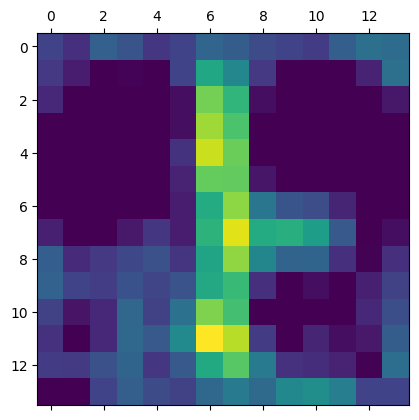

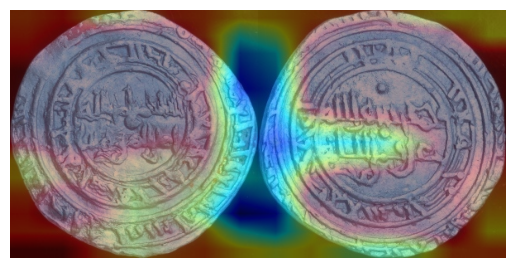

In [15]:
# Function to generate Grad-CAM for the fine-tuned model
def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    grads = tape.gradient(top_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Load and preprocess the image
img_path = 'Combined_images/combined_151152.1.jpg_151152.2.jpg'  # Replace with your image path
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, img_array)

# Display the heatmap
plt.matshow(heatmap)
plt.show()


# show the gradcam on the image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

In [19]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 600, 3))

# Create a model to extract features
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(model, images):
    features = []
    for img in images:
        img = preprocess_input(img)  # Preprocess the image as required by VGG16
        img = np.expand_dims(img, axis=0)  # Add a batch dimension
        feature = model.predict(img)
        features.append(feature.flatten())  # Flatten the feature map
    return np.array(features)

X_features = extract_features(model, X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
# save the model to disk
filename = 'features_model.sav'
pickle.dump(model, open(filename, 'wb'))

# save the features to disk
filename = 'features.sav'
pickle.dump(X_features, open(filename, 'wb'))

In [23]:
# load the features from disk
X_features = pickle.load(open('features.sav', 'rb'))

In [24]:
# Split the data into training and testing sets
X_train_features, X_test_features, y_train, y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42, stratify=Y)
X_train_features, X_val_features, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train)

#### Logistic regression Model

In [25]:
# Train a logistic regression classifier
LogisticRegression_model = LogisticRegression(max_iter=1000)
LogisticRegression_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = LogisticRegression_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')

# Test the model
y_test_pred = LogisticRegression_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.96
Test accuracy: 0.92


#####  Xgboost Model

In [26]:
# Train xgboost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')


# Test the model
y_test_pred = xgb_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.86
Test accuracy: 0.85


##### SVM Model

In [27]:
# Train svm model
svm_model = SVC(C=1.0, kernel='linear')
svm_model.fit(X_train_features, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_val_features)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.2f}')

# Test the model
y_test_pred = svm_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_accuracy:.2f}')


Validation accuracy: 0.95
Test accuracy: 0.93


In [37]:
# Load your pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    grads = tape.gradient(top_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# Load and preprocess the image
img_path = 'Combined_images/combined_151119.1.jpg_151119.2.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, img_array)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on the original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# Convert the image to the appropriate depth
superimposed_img = cv2.convertScaleAbs(superimposed_img)

cv2.imwrite('gradcam_output.jpg', superimposed_img)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

TypeError: list indices must be integers or slices, not tuple